In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import json

import nltk
from nltk.tokenize import word_tokenize
import spacy
import re

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer

import tqdm as notebook_tqdm

# Text Embedding + Topic Modeling
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
df = pd.read_csv('processedraw_data.csv')

### Text Embedding and Topic Modelling

**UMAP Tuning**
- tweaking the `n_neighbors`, `n_components`, and `min_dist` parameters to achieve better embedding separation
- `n_neighbors` controls local vs global structure; lower values focus on local structure and vice versa
- `min_dist` controls the compactness of clusters; lower values help form tighter clusters

experiment with different **embedding models**
- `paraphrase-MiniLM-L6-v2`
- `all-MiniLM-L6-v2`
- could provide better contextual embeddings for clustering

In [7]:
# initializing sentence transformer
embed_model = SentenceTransformer("BAAI/bge-small-en")

# generating text embeddings
text_embeddings = embed_model.encode(df['raw_processed'].tolist(), show_progress_bar=True)

# UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine')
# n_neighbors = defines how many neighboring points UMAP looks at for each point to estimate its local structure
# n_components = specifies the number of dimensions in the reduced space, or target dimensionality after reduction
# min_dist = 0, because our goal is to cluster
# cosine = commonly used for text and embeddings because it measures the angle between vectors, which is useful when the magnitude is less important than direction
reduced_text_embeddings = umap_model.fit_transform(text_embeddings)

Batches: 100%|██████████| 40/40 [01:51<00:00,  2.78s/it]


**HDBSCAN Tuning**
- adjust `min_cluster_size`, `min_samples`, and `cluster_selection_method='leaf` for a hierarchical structure to capture finer details within clusters
- `min_cluster_size` larger values form bigger clusters, smaller values allow more granular clustering
- `cluster_selection_method` use 'leaf' to allow finer clusters to be formed from larger ones

In [8]:
# HDBSCAN for clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=40, # minimum number of points to form a cluster
    metric='euclidean', # distance metric used to measure the distance between data points
    min_samples=5, # controls the number of points in a neighborhood for a point to be considered as a core point
    prediction_data=False
)
text_cluster = hdbscan_model.fit(reduced_text_embeddings)
df['cluster'] = text_cluster.labels_

In [9]:
# cosine similarity for document selection within each cluster
top_n = 10  # number of top documents to retrieve
diversity = 0.5  # balance between diversity and relevance
cluster_dict = {}

use **cluster centroids** for representative documents
- select documents closest to the centroid as the most representative - could provide a more accurate reflection of each cluster's central theme

use **sentence similarity** for MMR
- instead of cosine similarity on tf-idf vectors, use on the original sentence embeddings (from SentenceTransformer) - could give better results in terms of finding semantically similar documents within a cluster

In [10]:
# Loop through each cluster to find the most representative documents
for cluster, df_cluster in df.groupby('cluster'):
    if cluster == -1:
        # Skip noise
        continue
    
    # Convert documents to vectors using TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df_cluster['raw_processed'].tolist())
    
    # Find cosine similarity between all documents in this cluster
    candidate_d = cosine_similarity(X)
    candidate_d_sum = candidate_d.sum(axis=1)
    
    # First document is the most representative
    doc_list = [np.argmax(candidate_d_sum)]
    candidates_idx = [i for i in range(len(df_cluster)) if i != doc_list[0]]
    
    # Filter based on Maximal Marginal Relevance (MMR)
    for _ in range(top_n - 1):
        candidate_similarities = candidate_d_sum[candidates_idx]
        target_similarities = np.max(candidate_d[candidates_idx][:, doc_list], axis=1)
        
        # MMR formula
        mmr = (1 - diversity) * candidate_similarities - diversity * target_similarities
        
        # Update doc_list and candidates
        mmr_idx = candidates_idx[np.argmax(mmr)]
        doc_list.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
    
    # Store top documents for the cluster
    cluster_dict[cluster] = {
        'docs': [df_cluster['raw_processed'].tolist()[idx] for idx in doc_list]
    }

# cluster_dict = dictionary with top documents for each cluster

**MMR (Maximal Margin Relevance)**
An algorithm used in information retrieval and document summarization to select a subset of items (like documents) that are both relevant to a query and diverse from each other. 

Main goal = maximize the relevance of the selected items while minimizing redundancy

The MMR algorithm works based on two primary concepts:
1. Relevance: How elevant a document is to a given query or context
2. Diversity: How different or dissimilar a document is from the already selected documents

#### Visualizations

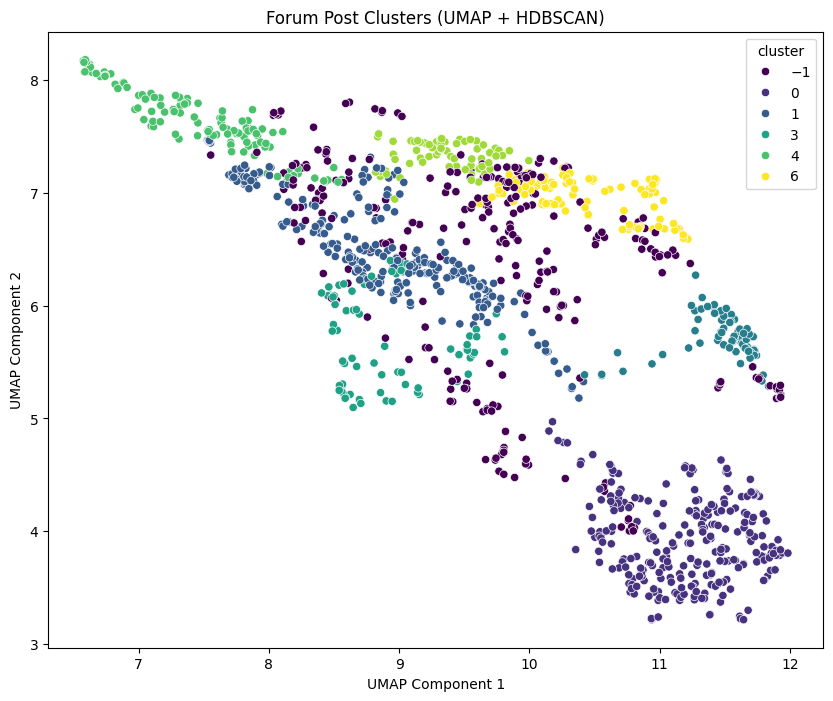

In [11]:
# visualize the UMAP-reduced embeddings with cluster coloring
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_text_embeddings[:, 0], y=reduced_text_embeddings[:, 1], hue=df['cluster'], palette='viridis')
plt.title('Forum Post Clusters (UMAP + HDBSCAN)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

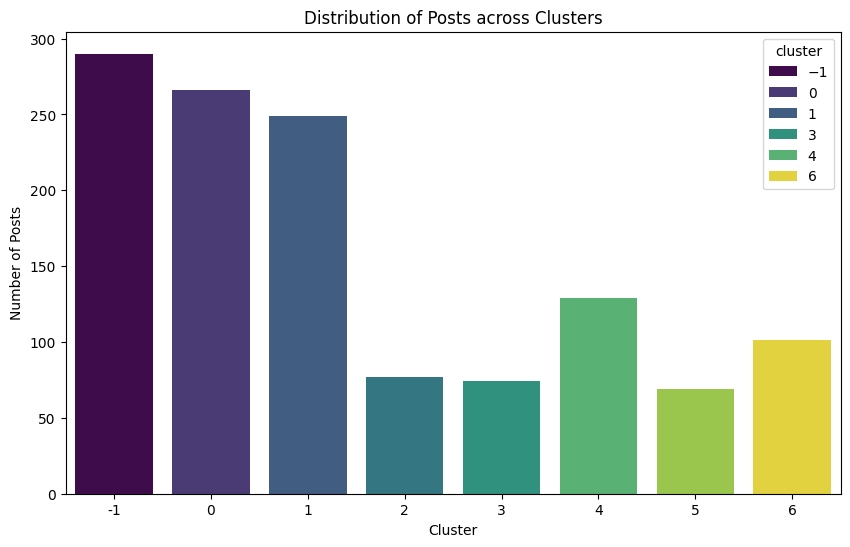

In [12]:
# cluster distribution bar chart -- show how many posts are present in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df, hue='cluster', palette='viridis')
plt.title('Distribution of Posts across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.show()

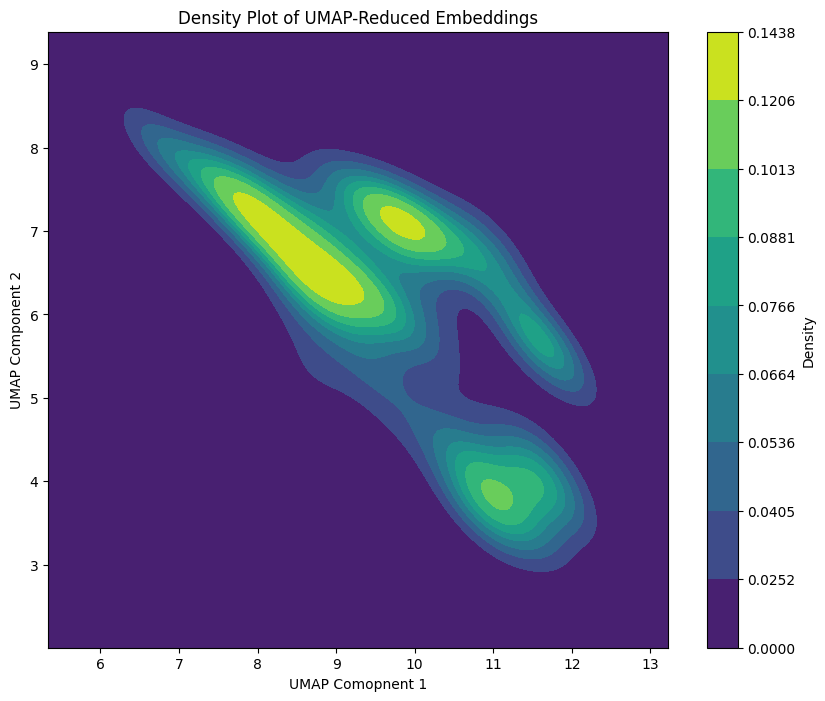

In [13]:
# 2d density plot, to visualize the concentration of points in different areas of the UMAP space
plt.figure(figsize=(10, 8))
kde = sns.kdeplot(x=reduced_text_embeddings[:, 0], y=reduced_text_embeddings[:, 1], # x and y coordinates for the KDE plot using the first and second components of the UMAP-reduced embeddings
                  fill=True, cmap='viridis', thresh=0) # fills area under KDE curves, threshold for density = 0, less than this value will not be plotted
plt.colorbar(kde.collections[0], label='Density')
plt.title('Density Plot of UMAP-Reduced Embeddings')
plt.xlabel('UMAP Comopnent 1')
plt.ylabel('UMAP Component 2')
plt.show()

# KDE plot - shows areas of high and low density in the UMAP-reduced space
# overlapping clusters - if different colors overlap significantly, may indicate that those groups are closely related or share similarities in content
# data distribution - shape of the density plot can reveal whether the data is evenly distributed or if there are certain regions (or themes) that are more prevalent

In [14]:
# using plotly for interactive visualizations
fig = px.scatter(x=reduced_text_embeddings[:,0],
                 y=reduced_text_embeddings[:,1],
                 color=df['cluster'],
                 title='Interactive UMAP Clusters',
                 labels={'x': 'UMAP Component 1', 'y': 'UMAP Component 2'})
fig.show()

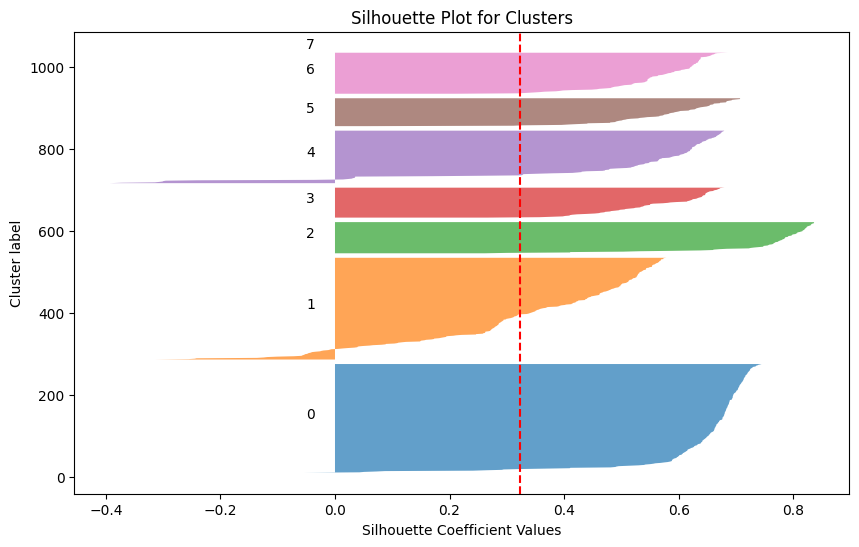

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
sample_silhouette_values = silhouette_samples(reduced_text_embeddings, df['cluster'])
silhouette_avg = silhouette_score(reduced_text_embeddings, df['cluster'])

# creating a silhouette plot
plt.figure(figsize=(10, 6))
y_lower=10 # starting position for silhouette values

for i in range(len(df['cluster'].unique())):
    # aggregate the silhouette scores for the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[df['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    # compute the y position for each cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # fill the silhouette plot with the cluster silhouette values
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)

    # label the cluster
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))

    # update the y_lower for the next cluster
    y_lower = y_upper +10

plt.title('Silhouette Plot for Clusters')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster label')
plt.axvline(x=silhouette_avg, color='red', linestyle='--') # line for the average score
plt.show()

# values close to 1 indicate that the points are well clustered
# values close to 0 indicate overlapping clusters
# negative values indicate that points may have been assigned to the wrong clusters

consider **filtering out noise (-1 cluster)** more effectively
-  `noise cluster (-1)` instead of simply ignoring the noise, reprocess or recluster these noisy points
- sometimes they're outliers, but they can still belong to meaningful subtopics that were missed in the first clustering pass
- re-run HDBSCAN on the noise points using a lower `min_cluster_size` to capture smaller but potentially meaningful clusters

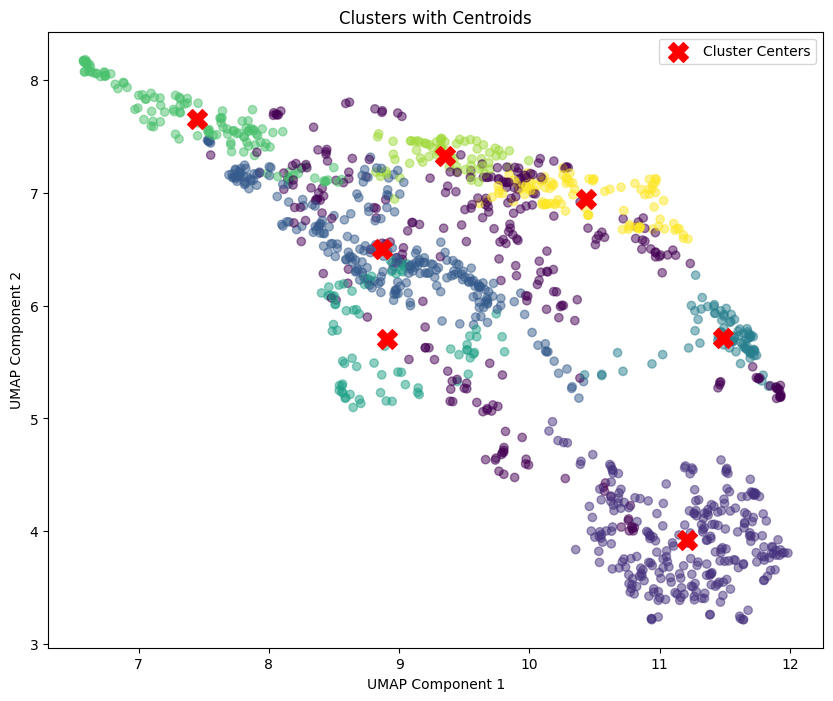

In [16]:
# visualize centroids of each cluster
cluster_centers = np.array([reduced_text_embeddings[df['cluster'] == c].mean(axis=0) for c in df['cluster'].unique() if c != -1])

plt.figure(figsize=(10,8))
plt.scatter(reduced_text_embeddings[:, 0], reduced_text_embeddings[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='X', s=200, label='Cluster Centers')
plt.title('Clusters with Centroids')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

**topic modelling** combine with **topic extraction** techniques
- `Latent Dirichlet Allocatioin (LDA)` apply LDA on the text within each cluster to extract coherent topics
-  `KeyBERT` use KeyBErt to extract keywords from each document cluster for topic summarization

### Fine-Tuning

In [46]:
silhouette_avg

0.32275862

In [ ]:
# original flow = silhoutte_avg=0.32275862

# fine tuned
# mix of BAAI/bge-small-en
# umap = n_neighbors 30, n_components 2, min_dist = 0
# hdbscan = min_cluster_size 20, min_samples 15, cluster_selection_method='leaf'
# avg silhouette score = 0.12549525

In [48]:
# initializing sentence transformer
embed_model_2 = SentenceTransformer("BAAI/bge-base-en")

# generating text embeddings
text_embeddings_2 = embed_model_2.encode(df['raw_processed'].tolist(), show_progress_bar=True)

c:\Users\Imaji Kasih\PycharmProjects\RNDRScrape_discourse-archive - Copy\rndr_venv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Imaji Kasih\.cache\huggingface\hub\models--BAAI--bge-base-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development

Batches: 100%|██████████| 40/40 [05:04<00:00,  7.62s/it]


In [65]:
# same model as original | not redefined, embed_model
# same text embeddings | not redefined, text_embeddings

# Updating UMAP
umap_model_2 = UMAP(n_neighbors=10, n_components=5, min_dist=0, metric='cosine') # random_state=42
reduced_text_embeddings_2 = umap_model_2.fit_transform(text_embeddings_2) 

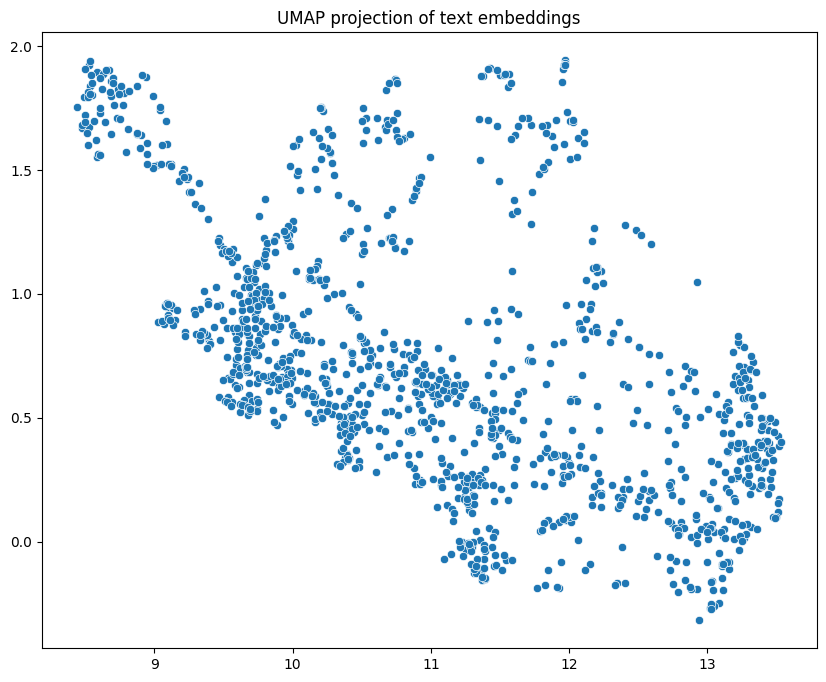

In [66]:
# visualize UMAP
plt.figure(figsize=(10,8))
sns.scatterplot(x=reduced_text_embeddings_2[:, 0], y=reduced_text_embeddings_2[:, 1])
plt.title('UMAP projection of text embeddings')
plt.show()

In [71]:
# Updating HDBSCAN
hdbscan_model_2 = HDBSCAN(
    min_cluster_size=40,
    min_samples=5,
    metric='euclidean' #,cluster_selection_method='leaf'
)

text_cluster_2 = hdbscan_model_2.fit(reduced_text_embeddings_2)
df['cluster_2'] = text_cluster_2.labels_

In [72]:
sample_silhouette_values_2 = silhouette_samples(reduced_text_embeddings_2, df['cluster_2'])
silhouette_avg_2 = silhouette_score(reduced_text_embeddings_2, df['cluster_2'])

In [73]:
silhouette_avg_2

0.26712453

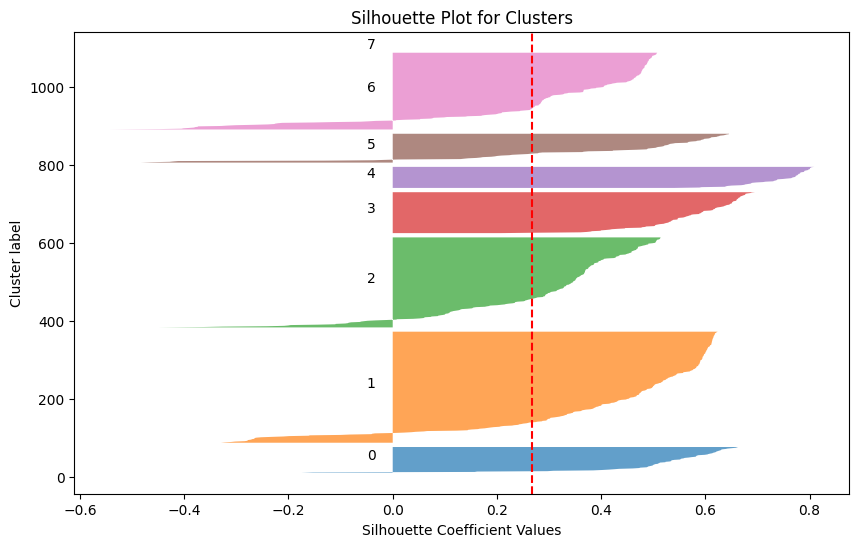

In [74]:
# creating a silhouette plot
plt.figure(figsize=(10, 6))
y_lower=10 # starting position for silhouette values

for i in range(len(df['cluster_2'].unique())):
    # aggregate the silhouette scores for the current cluster
    ith_cluster_silhouette_values_2 = sample_silhouette_values_2[df['cluster_2'] == i]
    ith_cluster_silhouette_values_2.sort()

    # compute the y position for each cluster
    size_cluster_i_2 = ith_cluster_silhouette_values_2.shape[0]
    y_upper = y_lower + size_cluster_i_2

    # fill the silhouette plot with the cluster silhouette values
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values_2, alpha=0.7)

    # label the cluster
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))

    # update the y_lower for the next cluster
    y_lower = y_upper +10

plt.title('Silhouette Plot for Clusters')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster label')
plt.axvline(x=silhouette_avg_2, color='red', linestyle='--') # line for the average score
plt.show()